Student Name: Wong Chong Ki

Student ID: 20978851

Student Email: ckwongch@connect.ust.hk

---

Steps to test:

 - Run all cells in **2. Model Definition (Vanilla RNN), 3. Training Setup, 4. Evaluation and Testing** respectively

 - Upload model files **'model_200.pth', 'model_2000.pth', 'model_20000.pth'**, and the **'test.txt'**

 - Run the cell in **6. My Test**, check the test result in the output window

### 1. Data Generation

In [ ]:
import random
import torch

# Helper function to check if a number is a palindrome
def is_palindrome(number):
  s = str(number)
  return s == s[::-1]

# Generate dataset
def generate_data(num_samples):
  print(f"Begin data generation ({num_samples})")
  data = []
  half_samples = num_samples // 2  # For equal palindromic and non-palindromic samples

  # Generate palindromic numbers
  for _ in range(half_samples):
    digits = random.randint(1, 5)
    half = ''.join([str(random.randint(0, 9)) for _ in range((digits + 1) // 2)])
    palin = int(half + half[::-1][digits % 2:])
    data.append((palin, 1))  # Label 1 for palindrome

  # Generate non-palindromic numbers
  while len(data) < num_samples:
    digits = random.randint(1, 5)
    number = random.randint(10**(digits - 1), 10**digits - 1)
    if not is_palindrome(number):
      data.append((number, 0))  # Label 0 for non-palindrome

  print(f"Data generation completed ({num_samples})")
  return data

# Save generated data to file
def save_data(data, filename):
  with open(filename, 'w') as f:
    for number, label in data:
      f.write(f"{number} {label}\n")

# Generate datasets
data_200 = generate_data(200)
save_data(data_200, "data_200.txt")
print("Saved data_200.txt\n")

data_2000 = generate_data(2000)
save_data(data_2000, "data_2000.txt")
print("Saved data_2000.txt\n")

data_20000 = generate_data(20000)
save_data(data_20000, "data_20000.txt")
print("Saved data_20000.txt\n")

my_test_1000 = generate_data(1000)
save_data(my_test_1000, "my_test_1000.txt")
print("Saved my_test_1000.txt")

Begin data generation (200)
Data generation completed (200)
Saved data_200.txt

Begin data generation (2000)
Data generation completed (2000)
Saved data_2000.txt

Begin data generation (20000)
Data generation completed (20000)
Saved data_20000.txt

Begin data generation (1000)
Data generation completed (1000)
Saved my_test_1000.txt


### 2. Model Definition (Vanilla RNN)

In [18]:
import torch.nn as nn

class PalindromeRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(PalindromeRNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)


### 3. Training Setup

In [19]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Parameters
n_hidden = 128
n_categories = 2  # Output: Palindrome or Not
n_letters = 10    # Digits 0-9 as input
learning_rate = 0.005

# Helper to convert number to tensor
def number_to_tensor(number):
  tensor = torch.zeros(len(str(number)), 1, n_letters)
  for i, digit in enumerate(str(number)):
    tensor[i][0][int(digit)] = 1
  return tensor

# Training function
def train(line_tensor, category_tensor, model, optimizer, criterion):
  hidden = model.initHidden()
  model.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = model(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()
  optimizer.step()

  return output, loss.item()

# Training loop with loss recording
def train_model(data, model, optimizer, criterion, epochs=100, print_every=10):
  all_losses = []
  for epoch in range(epochs):
    total_loss = 0
    for number, label in data:
      line_tensor = number_to_tensor(number)
      category_tensor = torch.tensor([label], dtype=torch.long)
      output, loss = train(line_tensor, category_tensor, model, optimizer, criterion)
      total_loss += loss
    average_loss = total_loss / len(data)
    all_losses.append(average_loss)

    if epoch % print_every == 0:
      print(f"Epoch {epoch}: Loss {average_loss}")
  return all_losses


### 4. Evaluation and Testing

In [20]:
# Function to plot training loss
def plot_loss(losses, title="Training Loss"):
  plt.figure()
  plt.plot(losses)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

# Function to save the model
def save_model(model, filename):
  torch.save(model.state_dict(), filename)
  print(f"Model saved to {filename}")

# Evaluation helper
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

# Test function
def test_model(data):
  correct = 0
  total = len(data)
  for number, label in data:
    line_tensor = number_to_tensor(number)
    output = evaluate(line_tensor)
    guess = torch.argmax(output).item()
    if guess == label:
      correct += 1
  accuracy = correct / total
  print(f"Test Accuracy: {accuracy * 100:.2f}%")
  return accuracy

# Load data from file
def load_data(filename):
  data = []
  with open(filename, 'r') as f:
    for line in f:
      number, label = line.strip().split()
      data.append((int(number), int(label)))
  return data

def load_model(model, filename):
  model.load_state_dict(torch.load(filename))
  model.eval()  # Set to evaluation mode
  print(f"Model loaded from {filename}")
  return model

# Evaluation helper function
def evaluate(model, line_tensor):
  hidden = model.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = model(line_tensor[i], hidden)
  return output

# Test function to calculate accuracy
def test_model(model, test_data):
  correct = 0
  total = len(test_data)
  for number, label in test_data:
    line_tensor = number_to_tensor(number)
    output = evaluate(model, line_tensor)
    guess = torch.argmax(output).item()
    if guess == label:
      correct += 1
  accuracy = correct / total
  print(f"Test Accuracy: {accuracy * 100:.2f}%")
  return accuracy

### 5. Running and Saving Results

In [ ]:
# Load datasets
data_200 = load_data("data_200.txt")
data_2000 = load_data("data_2000.txt")
data_20000 = load_data("data_20000.txt")

# Loss function
criterion = nn.NLLLoss()

Training model on 200 samples...
Epoch 0: Loss 0.6535091319680214
Epoch 10: Loss 0.5722469117864967
Epoch 20: Loss 0.4652238061418757
Epoch 30: Loss 0.39042724579485366
Epoch 40: Loss 0.3730100183522882
Epoch 50: Loss 0.3678655177687597
Epoch 60: Loss 0.3662584053396904
Epoch 70: Loss 0.36592350343122915
Epoch 80: Loss 0.3664306541408496
Epoch 90: Loss 0.36763345439381395


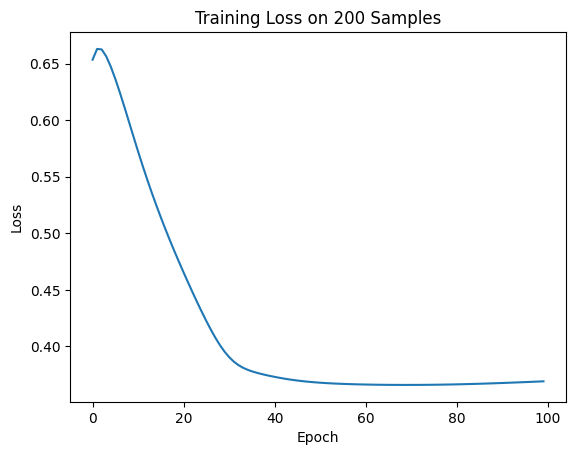

Model saved to model_200.pth


In [ ]:
# Model for 200 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
print("Training model on 200 samples...")
loss_200 = train_model(data_200, rnn, optimizer, criterion, epochs=100)
plot_loss(loss_200, title="Training Loss on 200 Samples")
save_model(rnn, "model_200.pth")

In [17]:
# Model for 2000 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)  # Reinitialize model
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
print("Training model on 2000 samples...")
loss_2000 = train_model(data_2000, rnn, optimizer, criterion, epochs=40)
plot_loss(loss_2000, title="Training Loss on 2000 Samples")
save_model(rnn, "model_2000.pth")

Training model on 2000 samples...


NameError: name 'data_2000' is not defined

Training model on 20000 samples...
Epoch 0: Loss 0.023393663501881615


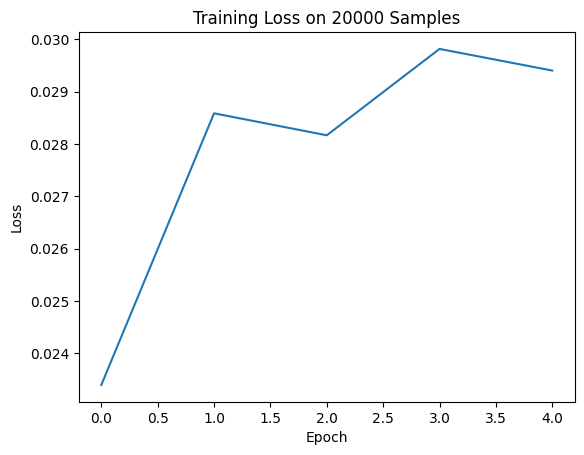

Model saved to model_20000.pth


In [ ]:
# Model for 20000 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)  # Reinitialize model
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
print("Training model on 20000 samples...")
loss_20000 = train_model(data_20000, rnn, optimizer, criterion, epochs=5)
plot_loss(loss_20000, title="Training Loss on 20000 Samples")
save_model(rnn, "model_20000.pth")

### 6. My Test

In [21]:
# change the test_file_name here
test_file_name = "test.txt" # my_test_1000.txt

# Load test data
test_data = load_data(test_file_name)

# Test each saved model
# Model trained with 200 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)
load_model(rnn, "model_200.pth")
test_accuracy_200 = test_model(rnn, test_data)
print('-'*30)

# Model trained with 2000 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)
load_model(rnn, "model_2000.pth")
test_accuracy_2000 = test_model(rnn, test_data)
print('-'*30)

# Model trained with 20000 samples
rnn = PalindromeRNN(n_letters, n_hidden, n_categories)
load_model(rnn, "model_20000.pth")
test_accuracy_20000 = test_model(rnn, test_data)
print('-'*30)

<ipython-input-20-13d2bcc588ca>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


Model loaded from model_200.pth
Test Accuracy: 53.30%
------------------------------
Model loaded from model_2000.pth
Test Accuracy: 59.40%
------------------------------
Model loaded from model_20000.pth
Test Accuracy: 59.40%
------------------------------
